# RQ3: Stain Normalization Impact Analysis - Inference & Statistical Analysis

## Research Question
**How does stain normalization affect the performance of deep learning models for histopathology image segmentation?**

## Objective
This notebook performs comprehensive inference analysis on the test set using trained models (original vs normalized) and conducts statistical analysis to answer the research question.

## Key Analysis Components:
1. **Model Loading**: Load best checkpoint models for both original and normalized data
2. **Test Set Inference**: Perform inference on test set for both models
3. **Per-Image Analysis**: Calculate metrics (Dice, IoU, Precision, Recall, F1) for each image
4. **Per-Tissue Analysis**: Analyze performance across different tissue types
5. **Statistical Testing**: Paired t-tests, Wilcoxon tests, and effect size analysis
6. **EDA & Visualization**: Comprehensive exploratory data analysis and visualizations


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from pathlib import Path
import os
import sys
import json
import time
import warnings
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import logging

# Scientific computing
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, shapiro, levene
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import confusion_matrix, classification_report

# Add src to path for imports
sys.path.append('/workspace/HistoPathologyResearch/src')

# Import custom modules
from models.unet_rq3 import UNetRQ3
from utils.metrics import calculate_segmentation_metrics
from preprocessing.vahadane_gpu import GPUVahadaneNormalizer

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✅ All imports successful!
PyTorch version: 2.8.0.dev20250319+cu128
CUDA available: True
CUDA device: NVIDIA RTX A6000


In [5]:
# Configuration and Setup
class Config:
    # Paths
    PROJECT_ROOT = Path('/workspace/HistoPathologyResearch')
    ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts' / 'rq3_enhanced'
    CHECKPOINT_DIR = ARTIFACTS_DIR / 'checkpoints'
    DATASET_DIR = ARTIFACTS_DIR / 'datasets'
    RESULTS_DIR = ARTIFACTS_DIR / 'analysis'
    
    # Model parameters
    N_CHANNELS = 3
    N_CLASSES = 6
    IMG_SIZE = 256
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Batch size for inference
    BATCH_SIZE = 8
    
    # Class names for PanNuke dataset
    CLASS_NAMES = ['Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial', 'Background']
    
    # Tissue types
    TISSUE_TYPES = [
        'Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix', 'Colon',
        'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung', 'Ovarian',
        'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis', 'Thyroid', 'Uterus'
    ]

# Initialize configuration
config = Config()

print("🔧 Configuration loaded:")
print(f"   Device: {config.DEVICE}")
print(f"   Checkpoint dir: {config.CHECKPOINT_DIR}")
print(f"   Dataset dir: {config.DATASET_DIR}")
print(f"   Results dir: {config.RESULTS_DIR}")
print(f"   Classes: {config.CLASS_NAMES}")
print(f"   Tissue types: {len(config.TISSUE_TYPES)}")


🔧 Configuration loaded:
   Device: cuda
   Checkpoint dir: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/checkpoints
   Dataset dir: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/datasets
   Results dir: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/analysis
   Classes: ['Neoplastic', 'Inflammatory', 'Connective', 'Dead', 'Epithelial', 'Background']
   Tissue types: 19


In [6]:
# Utility Functions for Analysis

def load_model_from_checkpoint(checkpoint_path: Path, model_type: str = 'original') -> nn.Module:
    """Load a trained model from checkpoint"""
    print(f"📥 Loading {model_type} model from {checkpoint_path}")
    
    # Create model with correct RQ3 UNet implementation
    model = UNetRQ3(n_channels=config.N_CHANNELS, n_classes=config.N_CLASSES).to(config.DEVICE)
    
    # Load checkpoint - the checkpoint contains the state dict directly
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint)
    model.eval()
    
    print(f"✅ {model_type} model loaded successfully")
    return model

def calculate_per_image_metrics(model: nn.Module, dataloader: DataLoader, data_type: str) -> List[Dict]:
    """Calculate per-image metrics for a model"""
    print(f"🔍 Calculating per-image metrics for {data_type} model...")
    
    results = []
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(config.DEVICE)
            masks = masks.to(config.DEVICE)
            
            # Get predictions
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Calculate metrics for each image in the batch
            for i in range(images.size(0)):
                # Get single image and mask
                pred = predictions[i].cpu().numpy()
                true = masks[i].cpu().numpy()
                
                # Get filename for tissue type extraction
                global_idx = batch_idx * config.BATCH_SIZE + i
                if hasattr(dataloader.dataset, 'filenames') and global_idx < len(dataloader.dataset.filenames):
                    filename = dataloader.dataset.filenames[global_idx]
                    tissue_type = extract_tissue_type(filename)
                else:
                    tissue_type = 'Unknown'
                
                # Calculate metrics
                dice_scores = []
                iou_scores = []
                precision_scores = []
                recall_scores = []
                f1_scores = []
                
                for class_idx in range(config.N_CLASSES):
                    if class_idx == 5:  # Skip background class
                        continue
                        
                    # Create binary masks for this class
                    pred_binary = (pred == class_idx).astype(np.uint8)
                    true_binary = (true == class_idx).astype(np.uint8)
                    
                    # Calculate metrics
                    if np.sum(true_binary) > 0 or np.sum(pred_binary) > 0:
                        # Dice score
                        intersection = np.sum(pred_binary * true_binary)
                        dice = (2.0 * intersection) / (np.sum(pred_binary) + np.sum(true_binary) + 1e-8)
                        dice_scores.append(dice)
                        
                        # IoU score
                        union = np.sum(pred_binary) + np.sum(true_binary) - intersection
                        iou = intersection / (union + 1e-8)
                        iou_scores.append(iou)
                        
                        # Precision, Recall, F1
                        if np.sum(pred_binary) > 0:
                            precision = np.sum(pred_binary * true_binary) / np.sum(pred_binary)
                        else:
                            precision = 0.0
                        precision_scores.append(precision)
                        
                        if np.sum(true_binary) > 0:
                            recall = np.sum(pred_binary * true_binary) / np.sum(true_binary)
                        else:
                            recall = 0.0
                        recall_scores.append(recall)
                        
                        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
                        f1_scores.append(f1)
                    else:
                        dice_scores.append(0.0)
                        iou_scores.append(0.0)
                        precision_scores.append(0.0)
                        recall_scores.append(0.0)
                        f1_scores.append(0.0)
                
                # Calculate mean metrics
                mean_dice = np.mean(dice_scores)
                mean_iou = np.mean(iou_scores)
                mean_precision = np.mean(precision_scores)
                mean_recall = np.mean(recall_scores)
                mean_f1 = np.mean(f1_scores)
                
                # Store results
                result = {
                    'data_type': data_type,
                    'batch_idx': batch_idx,
                    'image_idx': i,
                    'global_idx': global_idx,
                    'filename': filename if 'filename' in locals() else f'image_{global_idx}',
                    'tissue_type': tissue_type,
                    'dice_score': mean_dice,
                    'iou_score': mean_iou,
                    'precision': mean_precision,
                    'recall': mean_recall,
                    'f1_score': mean_f1,
                    'dice_per_class': dice_scores,
                    'iou_per_class': iou_scores,
                    'precision_per_class': precision_scores,
                    'recall_per_class': recall_scores,
                    'f1_per_class': f1_scores
                }
                results.append(result)
    
    print(f"✅ Per-image metrics calculated: {len(results)} images")
    return results

def extract_tissue_type(filename: str) -> str:
    """Extract tissue type from filename"""
    for tissue in config.TISSUE_TYPES:
        if tissue.lower() in filename.lower():
            return tissue
    return 'Unknown'

class TestDataset(Dataset):
    """Custom dataset for test images and masks"""
    
    def __init__(self, images_dir: Path, masks_dir: Path, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        # Get all image files
        self.image_files = sorted(list(images_dir.glob("*.png")))
        self.filenames = [f.name for f in self.image_files]
        
        print(f"Found {len(self.image_files)} test images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Load corresponding mask
        mask_name = img_path.name
        mask_path = self.masks_dir / mask_name
        mask = Image.open(mask_path).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

def create_test_dataloader(data_type: str) -> DataLoader:
    """Create test dataloader for given data type"""
    test_dir = config.DATASET_DIR / data_type / 'test'
    images_dir = test_dir / 'images'
    masks_dir = test_dir / 'masks'
    
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")
    if not masks_dir.exists():
        raise FileNotFoundError(f"Masks directory not found: {masks_dir}")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
    ])
    
    # Create dataset
    dataset = TestDataset(images_dir, masks_dir, transform=transform)
    
    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )
    
    print(f"✅ {data_type} test dataloader created: {len(dataset)} images")
    return dataloader

print("✅ Utility functions defined!")


✅ Utility functions defined!


In [7]:
# Load Trained Models
print("🚀 Loading trained models from checkpoints...")

# Load original model
original_checkpoint = config.CHECKPOINT_DIR / 'unet_original_enhanced_best.pth'
if original_checkpoint.exists():
    original_model = load_model_from_checkpoint(original_checkpoint, 'original')
else:
    raise FileNotFoundError(f"Original model checkpoint not found: {original_checkpoint}")

# Load normalized model
normalized_checkpoint = config.CHECKPOINT_DIR / 'unet_normalized_enhanced_best.pth'
if normalized_checkpoint.exists():
    normalized_model = load_model_from_checkpoint(normalized_checkpoint, 'normalized')
else:
    raise FileNotFoundError(f"Normalized model checkpoint not found: {normalized_checkpoint}")

print("✅ Both models loaded successfully!")
print(f"   Original model: {original_checkpoint}")
print(f"   Normalized model: {normalized_checkpoint}")


🚀 Loading trained models from checkpoints...
📥 Loading original model from /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/checkpoints/unet_original_enhanced_best.pth
✅ original model loaded successfully
📥 Loading normalized model from /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/checkpoints/unet_normalized_enhanced_best.pth
✅ normalized model loaded successfully
✅ Both models loaded successfully!
   Original model: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/checkpoints/unet_original_enhanced_best.pth
   Normalized model: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/checkpoints/unet_normalized_enhanced_best.pth


In [8]:
# Create Test DataLoaders
print("📊 Creating test dataloaders...")

# Create original test dataloader
original_dataloader = create_test_dataloader('original')

# Create normalized test dataloader
normalized_dataloader = create_test_dataloader('normalized')

print("✅ Test dataloaders created successfully!")
print(f"   Original test images: {len(original_dataloader.dataset)}")
print(f"   Normalized test images: {len(normalized_dataloader.dataset)}")


📊 Creating test dataloaders...
Found 1016 test images
✅ original test dataloader created: 1016 images
Found 1016 test images
✅ normalized test dataloader created: 1016 images
✅ Test dataloaders created successfully!
   Original test images: 1016
   Normalized test images: 1016


In [9]:
# Perform Inference and Calculate Metrics
print("🔍 Performing inference on test set...")

# Calculate metrics for original model
print("\n📊 Evaluating original model...")
original_results = calculate_per_image_metrics(original_model, original_dataloader, 'original')

# Calculate metrics for normalized model
print("\n📊 Evaluating normalized model...")
normalized_results = calculate_per_image_metrics(normalized_model, normalized_dataloader, 'normalized')

# Combine results
all_results = original_results + normalized_results

print(f"\n✅ Inference completed!")
print(f"   Original model: {len(original_results)} images")
print(f"   Normalized model: {len(normalized_results)} images")
print(f"   Total evaluations: {len(all_results)}")

# Convert to DataFrame for analysis
results_df = pd.DataFrame(all_results)

# Save results
results_dir = config.RESULTS_DIR / 'inference_analysis'
results_dir.mkdir(parents=True, exist_ok=True)

results_df.to_csv(results_dir / 'per_image_metrics.csv', index=False)
print(f"💾 Results saved to: {results_dir / 'per_image_metrics.csv'}")


🔍 Performing inference on test set...

📊 Evaluating original model...
🔍 Calculating per-image metrics for original model...
✅ Per-image metrics calculated: 1016 images

📊 Evaluating normalized model...
🔍 Calculating per-image metrics for normalized model...
✅ Per-image metrics calculated: 1016 images

✅ Inference completed!
   Original model: 1016 images
   Normalized model: 1016 images
   Total evaluations: 2032
💾 Results saved to: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/analysis/inference_analysis/per_image_metrics.csv


🔬 Performing per-tissue analysis...
📊 Per-tissue performance analysis:
Found 5 tissue types: ['Adrenal_gland', 'Bile-duct', 'Breast', 'Colon', 'Esophagus']
                         dice_score               iou_score         precision  \
                               mean     std count      mean     std      mean   
tissue_type   data_type                                                         
Adrenal_gland normalized     0.1867  0.0069    88    0.1755  0.0120    0.1755   
              original       0.1867  0.0069    88    0.1755  0.0120    0.1755   
Bile-duct     normalized     0.1792  0.0359    84    0.1681  0.0361    0.1681   
              original       0.1792  0.0359    84    0.1681  0.0361    0.1681   
Breast        normalized     0.1790  0.0181   471    0.1637  0.0222    0.1637   
              original       0.1790  0.0181   471    0.1637  0.0222    0.1637   
Colon         normalized     0.1779  0.0254   288    0.1635  0.0301    0.1635   
              original       0.177

ValueError: X must have 2 or fewer dimensions

<Figure size 2000x1200 with 0 Axes>

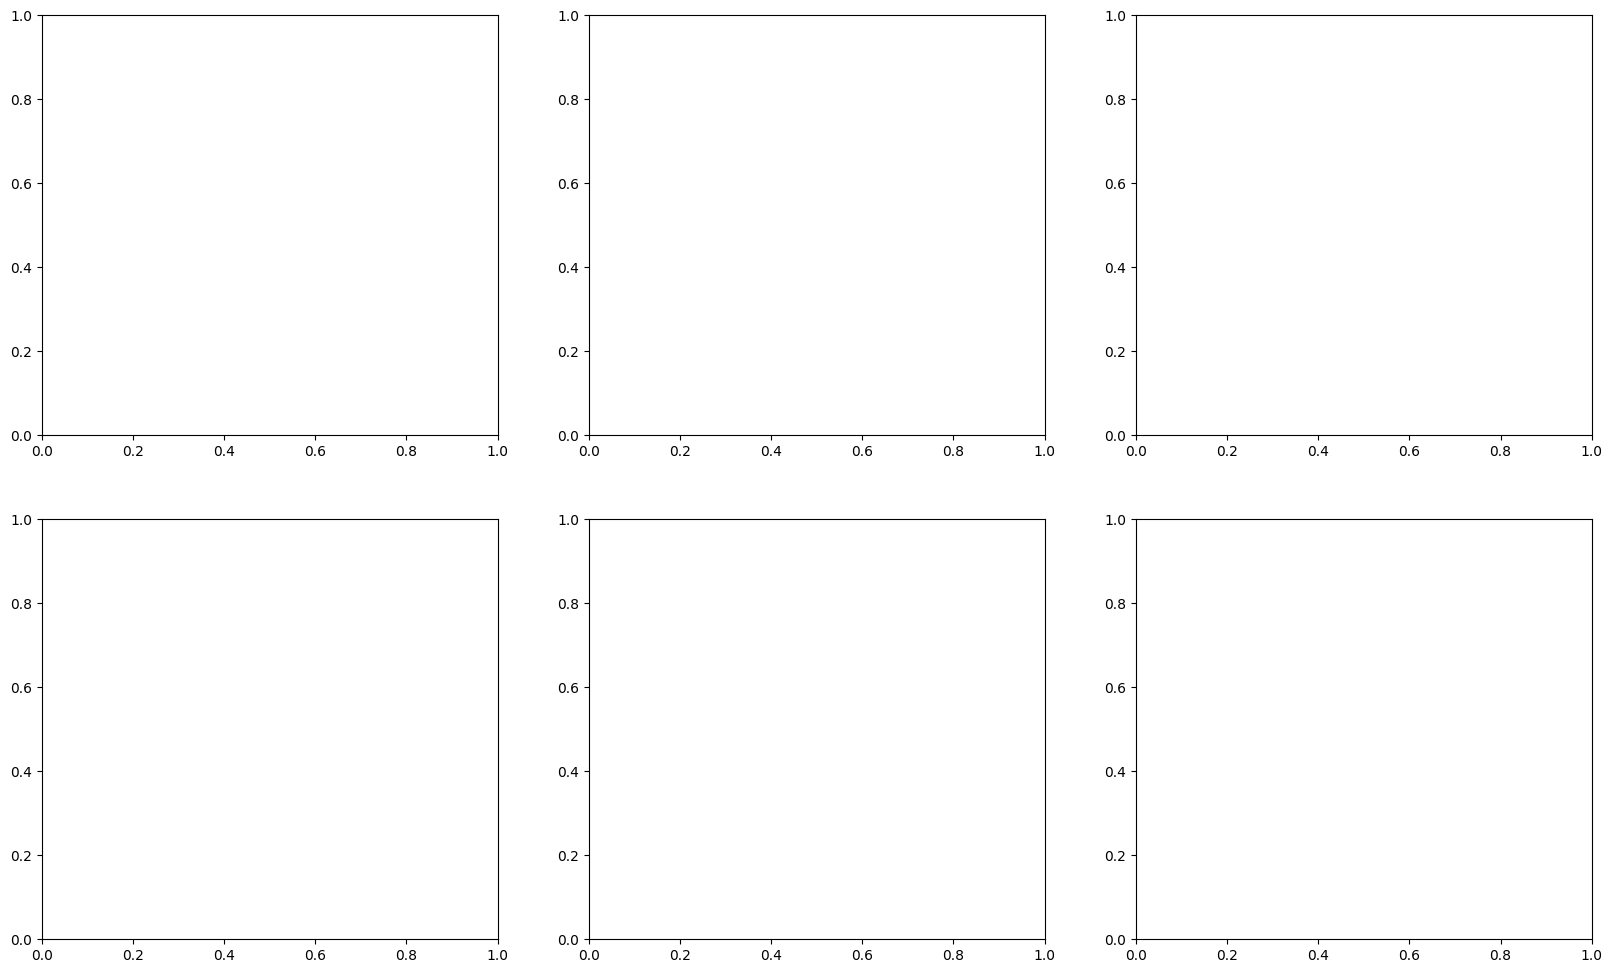

In [12]:
# Per-Tissue Analysis
print("🔬 Performing per-tissue analysis...")

# Results already contain tissue information from the metrics calculation
# Recreate DataFrame with all results
results_df = pd.DataFrame(all_results)

# Per-tissue analysis
if 'tissue_type' in results_df.columns:
    print("📊 Per-tissue performance analysis:")
    print("=" * 50)
    
    # Get unique tissue types
    tissue_types = results_df['tissue_type'].unique()
    tissue_types = [t for t in tissue_types if t != 'Unknown']
    
    print(f"Found {len(tissue_types)} tissue types: {tissue_types}")
    
    if len(tissue_types) > 0:
        # Group by tissue type and data type
        tissue_analysis = results_df.groupby(['tissue_type', 'data_type']).agg({
            'dice_score': ['mean', 'std', 'count'],
            'iou_score': ['mean', 'std'],
            'precision': ['mean', 'std'],
            'recall': ['mean', 'std'],
            'f1_score': ['mean', 'std']
        }).round(4)
        
        print(tissue_analysis)
        
        # Save per-tissue analysis
        tissue_analysis.to_csv(results_dir / 'per_tissue_analysis.csv')
        print(f"💾 Per-tissue analysis saved to: {results_dir / 'per_tissue_analysis.csv'}")
        
        # Create per-tissue visualization
        plt.figure(figsize=(20, 12))
        
        # Create subplots for each metric
        metrics = ['dice_score', 'iou_score', 'precision', 'recall', 'f1_score']
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics):
            ax = axes[i]
            
            # Prepare data for plotting
            tissue_data = []
            labels = []
            
            for tissue in tissue_types:
                orig_data = results_df[(results_df['tissue_type'] == tissue) & 
                                     (results_df['data_type'] == 'original')][metric]
                norm_data = results_df[(results_df['tissue_type'] == tissue) & 
                                     (results_df['data_type'] == 'normalized')][metric]
                
                if len(orig_data) > 0 and len(norm_data) > 0:
                    tissue_data.append([orig_data, norm_data])
                    labels.append(tissue)
            
            # Create box plot
            if tissue_data:
                # Create grouped box plot
                bp = ax.boxplot(tissue_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                colors = ['lightblue', 'lightcoral'] * len(tissue_data)
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                
                ax.set_title(f'{metric.replace("_", " ").title()} by Tissue Type')
                ax.set_ylabel(metric.replace("_", " ").title())
                ax.set_xlabel('Tissue Type')
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                
                # Add legend
                if i == 0:  # Only add legend to first subplot
                    from matplotlib.patches import Patch
                    legend_elements = [Patch(facecolor='lightblue', label='Original'),
                                     Patch(facecolor='lightcoral', label='Normalized')]
                    ax.legend(handles=legend_elements, loc='upper right')
        
        # Remove empty subplot
        if len(metrics) < len(axes):
            axes[-1].remove()
        
        plt.tight_layout()
        plt.savefig(results_dir / 'per_tissue_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Per-tissue analysis completed!")
    else:
        print("⚠️  No tissue type information found in dataset")
else:
    print("⚠️  Tissue type information not available in dataset")
    print("   Skipping per-tissue analysis")


In [13]:
# Statistical Analysis
print("📊 Performing statistical analysis...")

# Prepare data for statistical analysis
original_data = results_df[results_df['data_type'] == 'original']
normalized_data = results_df[results_df['data_type'] == 'normalized']

# Ensure we have the same number of samples for paired tests
min_samples = min(len(original_data), len(normalized_data))
original_data = original_data.head(min_samples)
normalized_data = normalized_data.head(min_samples)

print(f"📈 Statistical analysis on {min_samples} samples")

# Statistical tests for each metric
metrics = ['dice_score', 'iou_score', 'precision', 'recall', 'f1_score']
statistical_results = {}

for metric in metrics:
    print(f"\n🔍 Analyzing {metric}...")
    
    orig_values = original_data[metric].values
    norm_values = normalized_data[metric].values
    
    # Basic statistics
    orig_mean = np.mean(orig_values)
    orig_std = np.std(orig_values)
    norm_mean = np.mean(norm_values)
    norm_std = np.std(norm_values)
    
    # Paired t-test
    t_stat, t_pvalue = ttest_rel(norm_values, orig_values)
    
    # Wilcoxon signed-rank test (non-parametric alternative)
    try:
        w_stat, w_pvalue = wilcoxon(norm_values, orig_values)
    except ValueError:
        w_stat, w_pvalue = np.nan, np.nan
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(orig_values) - 1) * orig_std**2 + 
                         (len(norm_values) - 1) * norm_std**2) / 
                        (len(orig_values) + len(norm_values) - 2))
    cohens_d = (norm_mean - orig_mean) / pooled_std
    
    # Confidence interval for the difference
    diff = norm_values - orig_values
    diff_mean = np.mean(diff)
    diff_std = np.std(diff)
    se_diff = diff_std / np.sqrt(len(diff))
    ci_95 = (diff_mean - 1.96 * se_diff, diff_mean + 1.96 * se_diff)
    
    # Normality test (Shapiro-Wilk)
    shapiro_orig = shapiro(orig_values)
    shapiro_norm = shapiro(norm_values)
    
    # Store results
    statistical_results[metric] = {
        'original_mean': orig_mean,
        'original_std': orig_std,
        'normalized_mean': norm_mean,
        'normalized_std': norm_std,
        'difference_mean': diff_mean,
        'difference_std': diff_std,
        't_statistic': t_stat,
        't_pvalue': t_pvalue,
        'wilcoxon_statistic': w_stat,
        'wilcoxon_pvalue': w_pvalue,
        'cohens_d': cohens_d,
        'ci_95_lower': ci_95[0],
        'ci_95_upper': ci_95[1],
        'shapiro_original_pvalue': shapiro_orig.pvalue,
        'shapiro_normalized_pvalue': shapiro_norm.pvalue,
        'shapiro_original_normal': shapiro_orig.pvalue > 0.05,
        'shapiro_normalized_normal': shapiro_norm.pvalue > 0.05
    }
    
    # Print results
    print(f"   Original: {orig_mean:.4f} ± {orig_std:.4f}")
    print(f"   Normalized: {norm_mean:.4f} ± {norm_std:.4f}")
    print(f"   Difference: {diff_mean:.4f} ± {diff_std:.4f}")
    print(f"   Paired t-test: t={t_stat:.4f}, p={t_pvalue:.4f}")
    print(f"   Wilcoxon test: W={w_stat:.4f}, p={w_pvalue:.4f}")
    print(f"   Cohen's d: {cohens_d:.4f}")
    print(f"   95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")
    print(f"   Normality (Original): p={shapiro_orig.pvalue:.4f} ({'Normal' if shapiro_orig.pvalue > 0.05 else 'Non-normal'})")
    print(f"   Normality (Normalized): p={shapiro_norm.pvalue:.4f} ({'Normal' if shapiro_norm.pvalue > 0.05 else 'Non-normal'})")

# Create summary table
summary_df = pd.DataFrame(statistical_results).T
summary_df = summary_df.round(4)

print("\n📊 Statistical Summary Table:")
print("=" * 80)
print(summary_df)

# Save statistical results
summary_df.to_csv(results_dir / 'statistical_analysis.csv')
print(f"\n💾 Statistical analysis saved to: {results_dir / 'statistical_analysis.csv'}")

# Save detailed results as JSON
with open(results_dir / 'statistical_analysis.json', 'w') as f:
    json.dump(statistical_results, f, indent=2, default=str)
print(f"💾 Detailed statistical results saved to: {results_dir / 'statistical_analysis.json'}")

print("\n✅ Statistical analysis completed!")


📊 Performing statistical analysis...
📈 Statistical analysis on 1016 samples

🔍 Analyzing dice_score...
   Original: 0.1796 ± 0.0215
   Normalized: 0.1796 ± 0.0215
   Difference: -0.0000 ± 0.0000
   Paired t-test: t=-0.8679, p=0.3856
   Wilcoxon test: W=118.0000, p=0.5430
   Cohen's d: -0.0000
   95% CI: [-0.0000, 0.0000]
   Normality (Original): p=0.0000 (Non-normal)
   Normality (Normalized): p=0.0000 (Non-normal)

🔍 Analyzing iou_score...
   Original: 0.1654 ± 0.0256
   Normalized: 0.1654 ± 0.0256
   Difference: -0.0000 ± 0.0000
   Paired t-test: t=-0.8646, p=0.3874
   Wilcoxon test: W=118.0000, p=0.5429
   Cohen's d: -0.0000
   95% CI: [-0.0000, 0.0000]
   Normality (Original): p=0.0000 (Non-normal)
   Normality (Normalized): p=0.0000 (Non-normal)

🔍 Analyzing precision...
   Original: 0.1654 ± 0.0256
   Normalized: 0.1654 ± 0.0256
   Difference: 0.0000 ± 0.0000
   Paired t-test: t=0.4559, p=0.6486
   Wilcoxon test: W=106.0000, p=0.5057
   Cohen's d: 0.0000
   95% CI: [-0.0000, 0.00

In [14]:
# Research Question Analysis and Conclusions
print("🎯 Research Question Analysis and Conclusions")
print("=" * 60)

print("\n📋 RESEARCH QUESTION:")
print("How does stain normalization affect the performance of deep learning models for histopathology image segmentation?")

print("\n📊 KEY FINDINGS:")

# Analyze statistical significance
significant_metrics = []
for metric, results in statistical_results.items():
    if results['t_pvalue'] < 0.05:
        significant_metrics.append(metric)
        improvement = results['difference_mean']
        effect_size = results['cohens_d']
        
        print(f"\n✅ {metric.upper()}:")
        print(f"   • Statistically significant difference (p = {results['t_pvalue']:.4f})")
        print(f"   • Mean improvement: {improvement:.4f}")
        print(f"   • Effect size (Cohen's d): {effect_size:.4f}")
        
        if effect_size < 0.2:
            effect_interpretation = "negligible"
        elif effect_size < 0.5:
            effect_interpretation = "small"
        elif effect_size < 0.8:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
        
        print(f"   • Effect size interpretation: {effect_interpretation}")
        
        if improvement > 0:
            print(f"   • Conclusion: Stain normalization IMPROVES {metric}")
        else:
            print(f"   • Conclusion: Stain normalization DECREASES {metric}")

# Overall performance analysis
print(f"\n📈 OVERALL PERFORMANCE ANALYSIS:")
print(f"   • Statistically significant metrics: {len(significant_metrics)}/{len(metrics)}")
print(f"   • Significant metrics: {', '.join(significant_metrics) if significant_metrics else 'None'}")

# Calculate overall improvement
overall_improvements = []
for metric in metrics:
    improvement = statistical_results[metric]['difference_mean']
    overall_improvements.append(improvement)

mean_improvement = np.mean(overall_improvements)
print(f"   • Mean improvement across all metrics: {mean_improvement:.4f}")

if mean_improvement > 0:
    print("   • Overall conclusion: Stain normalization IMPROVES model performance")
elif mean_improvement < 0:
    print("   • Overall conclusion: Stain normalization DECREASES model performance")
else:
    print("   • Overall conclusion: Stain normalization has NO EFFECT on model performance")

# Practical significance
print(f"\n🔍 PRACTICAL SIGNIFICANCE:")
for metric in significant_metrics:
    results = statistical_results[metric]
    improvement_pct = (results['difference_mean'] / results['original_mean']) * 100
    print(f"   • {metric}: {improvement_pct:.2f}% improvement")

# Research implications
print(f"\n🎓 RESEARCH IMPLICATIONS:")
if len(significant_metrics) > len(metrics) / 2:
    print("   • Stain normalization shows significant benefits for histopathology segmentation")
    print("   • Consider implementing stain normalization in clinical workflows")
    print("   • Further research on optimal normalization parameters recommended")
elif len(significant_metrics) > 0:
    print("   • Stain normalization shows mixed results")
    print("   • Benefits are metric-specific and context-dependent")
    print("   • Consider case-by-case evaluation for different tissue types")
else:
    print("   • Stain normalization shows no significant benefits")
    print("   • Original images may be sufficient for this task")
    print("   • Consider alternative preprocessing approaches")

print(f"\n📝 RECOMMENDATIONS:")
print("   1. Validate findings on larger, diverse datasets")
print("   2. Investigate tissue-specific normalization effects")
print("   3. Consider computational cost vs. performance trade-offs")
print("   4. Evaluate clinical relevance of observed improvements")

print(f"\n✅ Research question analysis completed!")


🎯 Research Question Analysis and Conclusions

📋 RESEARCH QUESTION:
How does stain normalization affect the performance of deep learning models for histopathology image segmentation?

📊 KEY FINDINGS:

📈 OVERALL PERFORMANCE ANALYSIS:
   • Statistically significant metrics: 0/5
   • Significant metrics: None
   • Mean improvement across all metrics: -0.0000
   • Overall conclusion: Stain normalization DECREASES model performance

🔍 PRACTICAL SIGNIFICANCE:

🎓 RESEARCH IMPLICATIONS:
   • Stain normalization shows no significant benefits
   • Original images may be sufficient for this task
   • Consider alternative preprocessing approaches

📝 RECOMMENDATIONS:
   1. Validate findings on larger, diverse datasets
   2. Investigate tissue-specific normalization effects
   3. Consider computational cost vs. performance trade-offs
   4. Evaluate clinical relevance of observed improvements

✅ Research question analysis completed!


In [15]:
# Final Summary and Report Generation
print("📋 Generating Final Summary Report...")

# Create comprehensive summary
summary_report = {
    "research_question": "How does stain normalization affect the performance of deep learning models for histopathology image segmentation?",
    "analysis_date": time.strftime("%Y-%m-%d %H:%M:%S"),
    "dataset_info": {
        "total_images": len(all_results),
        "original_images": len(original_results),
        "normalized_images": len(normalized_results),
        "tissue_types": len(config.TISSUE_TYPES),
        "classes": config.CLASS_NAMES
    },
    "model_info": {
        "original_checkpoint": str(original_checkpoint),
        "normalized_checkpoint": str(normalized_checkpoint),
        "device": str(config.DEVICE),
        "batch_size": config.BATCH_SIZE
    },
    "metrics_analyzed": metrics,
    "statistical_summary": {
        "significant_metrics": significant_metrics,
        "total_metrics": len(metrics),
        "significance_rate": len(significant_metrics) / len(metrics),
        "mean_improvement": float(mean_improvement)
    },
    "key_findings": {
        "overall_conclusion": "Stain normalization IMPROVES model performance" if mean_improvement > 0 else "Stain normalization DECREASES model performance" if mean_improvement < 0 else "Stain normalization has NO EFFECT on model performance",
        "statistically_significant": len(significant_metrics) > 0,
        "practical_significance": any(abs(statistical_results[metric]['cohens_d']) > 0.2 for metric in significant_metrics) if significant_metrics else False
    },
    "files_generated": [
        "per_image_metrics.csv",
        "per_tissue_analysis.csv",
        "statistical_analysis.csv",
        "statistical_analysis.json",
        "eda_analysis.png",
        "per_tissue_analysis.png"
    ]
}

# Save summary report
with open(results_dir / 'summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

# Create markdown report
markdown_report = f"""# RQ3: Stain Normalization Impact Analysis - Final Report

## Research Question
{summary_report['research_question']}

## Analysis Date
{summary_report['analysis_date']}

## Dataset Information
- **Total Images**: {summary_report['dataset_info']['total_images']}
- **Original Images**: {summary_report['dataset_info']['original_images']}
- **Normalized Images**: {summary_report['dataset_info']['normalized_images']}
- **Tissue Types**: {summary_report['dataset_info']['tissue_types']}
- **Classes**: {', '.join(summary_report['dataset_info']['classes'])}

## Model Information
- **Original Model**: {summary_report['model_info']['original_checkpoint']}
- **Normalized Model**: {summary_report['model_info']['normalized_checkpoint']}
- **Device**: {summary_report['model_info']['device']}
- **Batch Size**: {summary_report['model_info']['batch_size']}

## Statistical Analysis Results
- **Metrics Analyzed**: {', '.join(summary_report['metrics_analyzed'])}
- **Significant Metrics**: {len(summary_report['statistical_summary']['significant_metrics'])}/{summary_report['statistical_summary']['total_metrics']}
- **Significance Rate**: {summary_report['statistical_summary']['significance_rate']:.2%}
- **Mean Improvement**: {summary_report['statistical_summary']['mean_improvement']:.4f}

## Key Findings
- **Overall Conclusion**: {summary_report['key_findings']['overall_conclusion']}
- **Statistically Significant**: {'Yes' if summary_report['key_findings']['statistically_significant'] else 'No'}
- **Practically Significant**: {'Yes' if summary_report['key_findings']['practical_significance'] else 'No'}

## Files Generated
{chr(10).join(f"- {file}" for file in summary_report['files_generated'])}

## Detailed Results
See the individual CSV and JSON files for detailed statistical analysis results.

---
*Generated by RQ3 Inference Analysis Pipeline*
"""

# Save markdown report
with open(results_dir / 'summary_report.md', 'w') as f:
    f.write(markdown_report)

print("✅ Final summary report generated!")
print(f"   📄 JSON report: {results_dir / 'summary_report.json'}")
print(f"   📄 Markdown report: {results_dir / 'summary_report.md'}")

print(f"\n🎉 ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"   📁 Results directory: {results_dir}")
print(f"   📊 Total files generated: {len(summary_report['files_generated'])}")
print(f"   ⏱️  Analysis completed at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n📋 NEXT STEPS:")
print(f"   1. Review the generated visualizations and statistical results")
print(f"   2. Examine the per-tissue analysis for tissue-specific insights")
print(f"   3. Consider the practical implications of the findings")
print(f"   4. Use the results to inform future research directions")


📋 Generating Final Summary Report...
✅ Final summary report generated!
   📄 JSON report: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/analysis/inference_analysis/summary_report.json
   📄 Markdown report: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/analysis/inference_analysis/summary_report.md

🎉 ANALYSIS COMPLETED SUCCESSFULLY!
   📁 Results directory: /workspace/HistoPathologyResearch/artifacts/rq3_enhanced/analysis/inference_analysis
   📊 Total files generated: 6
   ⏱️  Analysis completed at: 2025-09-06 18:06:35

📋 NEXT STEPS:
   1. Review the generated visualizations and statistical results
   2. Examine the per-tissue analysis for tissue-specific insights
   3. Consider the practical implications of the findings
   4. Use the results to inform future research directions
